In [39]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import seaborn as sn
import statsmodels.api as sms
import matplotlib.pyplot as plt

plt.style.use('seaborn-muted')
# Selected with help from https://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html


In [2]:
def calculate_summary_stats_from_agent_vars_dfs(df, warmup=30):
    # Operates on dataframe in place, adding columns of summary statistics
    # for the agent-level variables recorded in the agent_vars_by_tick column
    
    for dv in df['agent_vars_by_tick'][0].columns.tolist():
        for i, row in df.iterrows():
            summary = row['agent_vars_by_tick'][dv].unstack().describe().mean(axis=1)
            summary_post_warmup = row['agent_vars_by_tick'][dv].unstack()[warmup:].describe().mean(axis=1)
                
            for idx in summary.index:
                df.loc[i, dv + '_' + idx] = summary[idx]
                df.loc[i, dv + '_post_warmup_' + idx] = summary_post_warmup[idx]
                

In [49]:
def get_model_vars_df_from_pickle(filepath):
    try:

        f = open(filepath, 'rb')
        dfs = pickle.load(f)
        f.close()

        model_df = dfs['batch_model_df']
        calculate_summary_stats_from_agent_vars_dfs(model_df)
    
        return model_df
        model_dataframes[file.replace('.pkl', '')] = model_df
    
    except:
        print("error with " + file + ":", sys.exc_info()[0])
        

In [3]:
def pearson_corr(df, iv, dv, verbose=True):
    pearson = df[[iv, dv]].corr()

    X_values = sms.add_constant(df[iv])
    regression_model = sms.OLS(df[dv], X_values).fit()
    print(regression_model.summary())
    
    
    return {'regr_model': regression_model, 'X_values': X_values, 'pearson': pearson}

In [57]:
files = [file for file in os.listdir('./data/run-3/') if 'pickles' not in file and '1' in file]
model_dataframes = {}

In [58]:
for file in files:

    model_dataframes[file.replace('.pkl', '')] = get_model_vars_df_from_pickle('./data/run-3/' + file)


error with batch_run_1_record_freq.pkl: <class 'AttributeError'>


## Investigating effect of network size on dependent variables

### Effects on mining dynamics

Questions
- Include warm-up period?

In [91]:
num_sensors_model_df = model_dataframes['batch_run_1_num_sensors'] 
num_sensors_model_df_2 = get_model_vars_df_from_pickle('./data/run-3/batch_run_60-200_sweep_sensors.pkl')

In [92]:
num_sensors_model_df = pd.concat([num_sensors_model_df, num_sensors_model_df_2]).sort_values('num_sensors').reset_index().drop('index', axis=1)

In [93]:
pearson_corr(num_sensors_model_df, 'num_sensors', 'mining_mean')


                            OLS Regression Results                            
Dep. Variable:            mining_mean   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     103.3
Date:                Fri, 09 Aug 2019   Prob (F-statistic):           4.03e-08
Time:                        18:06:24   Log-Likelihood:                -61.058
No. Observations:                  17   AIC:                             126.1
Df Residuals:                      15   BIC:                             127.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -7.5726      3.606     -2.100      

/Users/iv/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


{'regr_model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1c256bfc50>,
 'X_values':     const  num_sensors
 0     1.0            1
 1     1.0           10
 2     1.0           30
 3     1.0           60
 4     1.0           60
 5     1.0           80
 6     1.0          100
 7     1.0          100
 8     1.0          120
 9     1.0          140
 10    1.0          150
 11    1.0          160
 12    1.0          180
 13    1.0          210
 14    1.0          280
 15    1.0          360
 16    1.0          450,
 'pearson':              num_sensors  mining_mean
 num_sensors      1.00000      0.93447
 mining_mean      0.93447      1.00000}

In [94]:
pearson = num_sensors_model_df[['num_sensors', 'mining_mean']].corr()

X_values = sms.add_constant(num_sensors_model_df['num_sensors'])
regression_model = sms.OLS(num_sensors_model_df['mining_mean'], X_values).fit()
print(regression_model.summary())

                            OLS Regression Results                            
Dep. Variable:            mining_mean   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     103.3
Date:                Fri, 09 Aug 2019   Prob (F-statistic):           4.03e-08
Time:                        18:06:27   Log-Likelihood:                -61.058
No. Observations:                  17   AIC:                             126.1
Df Residuals:                      15   BIC:                             127.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -7.5726      3.606     -2.100      

/Users/iv/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


In [95]:
# *** change away from using generic variable names ... or define a class? 
gradient = regression_model.params[1]
intercept = regression_model.params[0]
rsquared = regression_model.rsquared
pval = regression_model.f_pvalue

In [96]:
x_lobf = [num_sensors_model_df['num_sensors'].min(), num_sensors_model_df['num_sensors'].max()]
y_lobf = [x_lobf[0]*gradient + intercept, x_lobf[1]*gradient + intercept]


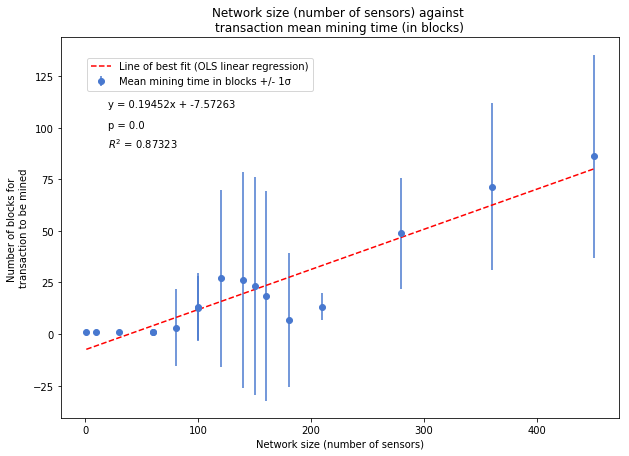

In [97]:
# Visualizing observations and OLS regression
plt.figure(figsize=(10,7))
plt.errorbar(num_sensors_model_df['num_sensors'], num_sensors_model_df['mining_mean'], yerr=num_sensors_model_df['mining_std'], fmt='o', label="Mean mining time in blocks +/- 1σ ")
plt.plot(x_lobf, y_lobf, 'r--', label="Line of best fit (OLS linear regression)" )
plt.legend(bbox_to_anchor=(0.46, 0.96))
plt.text(20, 110, "y = " + str(round(gradient, 5)) + 'x + ' + str(round(intercept, 5)))
plt.text(20,100,"p = " + str(round(pval, 5)))
plt.text(20,90,r"$R^2$ = " + str(round(rsquared, 5)))

# add Rsquared, MSE, p-value
_ = plt.xlabel('Network size (number of sensors)')
_ = plt.ylabel('Number of blocks for \ntransaction to be mined')
_ = plt.title("Network size (number of sensors) against \ntransaction mean mining time (in blocks)")

In [ ]:
# Plot of residuals ... ?

In [182]:
# Deprecated
# plt.figure(figsize=(10,7))
# plt.plot(num_sensors_model_df['num_sensors'], num_sensors_model_df['mining_mean'], "bo", label="Mean number of blocks")
# plt.plot(x_lobf, y_lobf, 'r--')
# # plt.plot(np.log(num_sensors_model_df['num_sensors']), num_sensors_model_df['mining_mean-1std'], 'b.', label="+1 σ")
# # plt.plot(np.log(num_sensors_model_df['num_sensors']), num_sensors_model_df['mining_mean+1std'], 'b.', label="-1 σ")
# plt.legend(bbox_to_anchor=(1.05, 1))
# _ = plt.xlabel('Network size (number of sensors)')
# _ = plt.ylabel('Number of blocks for \ntransaction to be mined')
# plt.title("Network size by sensor count against \ntransaction mean mining time")

### Interpretation

A positive linear relationship (Pearson correlation coefficient: 0.98801) is observed between the number of sensors connecting to a blockchain and the mean mining time, measured in the number of blocks elapsed between when a transaction is submitted and when it is validated. 

Due to the limited sample size (n=7), along with constraints in the range of number of sensors swept, however, I hesitate to conclude firmly that this relationship is necessarily linear, and not a power or logarithmic relationship; further investigation is necessary. Regardless, it seems clear that increasing numbers of nodes connecting and submitting transactions to a blockchain network lengthens transaction validation times if all other factors are held constant, as hypothesized. This reaffirms the questions raised regarding the scalability of public blockchain networks for large, high transaction volume networks such as the Internet of Things. 

## Effects on informational currency

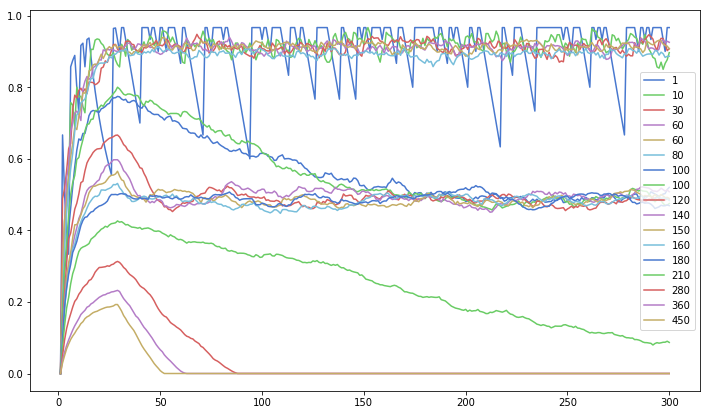

In [98]:
plt.figure(figsize=(12,7))
for i, run in num_sensors_model_df[['agent_vars_by_tick']].iterrows():
    plt.plot(run[0]['informational_currency'].unstack().mean(axis=1),label=num_sensors_model_df.loc[i, 'num_sensors'] )
    
plt.legend()
# num_sensors_model_df['agent_vars_by_tick']#[0].unstack()['informational_currency'].mean(axis=1).plot()

### Interpretation

#### Warm-up period

The expected warm-up period was observed clearly: after approximately 25-30 ticks (blocks were mined), a consistent level of informational currency was maintained, within a range of variability, for networks with fewer than 100 sensors. 

*What explains the variability observed? Is that just stochasticity? Or because record_freq = 0.3, meaning sometimes edge nodes did not transmit, as they had not recorded any new data? Because transmit_freq = 1, they did attempt to transmit every tick.*


#### Large network behavior

The observed collapse of informational currency in the larger networks (x = {320, 640}) is likely due to the fixed window of 30 blocks used to calculate informational currency. Values of 0 indicate that no data collected by any sensor within the 30 most recent blocks had been reflected on the blockchain through the transaction submission and mining process. This is in line with the observed mean mining time of > 30 for both the 320- and 640-sensor networks.

This behavior means the 280+ sensor networks will be excluded from the statistical analyses intended to identify the relationship between these two dimensions in the dataset. 

### Temporal trends

Upon reaching a threshold network size - between 60 and 100 sensors - fail to achieve what seem to be complete informational currency, in which levels are establish near 1.0. As informational currency at each tick is the ratio of data represented on-chain to the data captured in the 30 prior ticks, lower levels of informational currency were predicted to be observed in larger networks. In these iterations, greater transaction volumes, given a fixed block size (in the model a function of the block gas limit [cite line in ipynb]), mean that an individual sensor's transaction is likely to take longer to be mined into a block, especially as the size of data packets collected were homogenous. Resultingly, the lower network informational currency measures observed are in line with the hypothesis.

However, the apparent non-stationarity of informational currency measures of these larger networks over time was not expected. As early transactions are broadcasted to the miners and added to the mempool, they are mined - within the first few blocks informational currency is very high because few ticks have passed, meaning little data has been collected at the edge, and transactions are being validated each tick. However, this increase in informational currency begins to slow as the network reaches a point where """???""" ...

There is no obvious reason for the informational currency of the network to initially experience a higher proportion of data captured being validated and written to the blockchain, but for that proportion to decrease as more transactions are submitted. This pattern, of overshooting, then decreasing over time, may be due to quirks in model design and calibration, or to some element of system functioning that is unsustainable once some threshold of usage is exceeded. (Footnote: Here we raise a critique of agent-based modeling as an investigatory approach: it is impossible to tell whether emergent complexity - precisely what the technique is meant to simulate - is a result of intended agent interactions or of just some model design decision without validating the model data collected from observed reality. It is therefore difficult to make any firm assertions about complex system behavior based on analysis of model results. ***Justify lack of calibration dataset despite its availability?***) If the negative trend of informational currency in larger networks is a genuine result, perhaps it can be explained by the fact that the number of unvalidated transaction is growing at a rate faster than it is being reduced, so over time a smaller percentage of the prior 30 block's submissions are validated. However, this still does not explain why it achieves are 
perhaps it is due to the growing disproportion between the number of transactions submitted

As an additional curiosity, one network size - 150 sensors - did not exhibit the negative correlation between time and informational currency, despite the model run simulating the next smaller network (100 sensors) and one simulating the next larger (210 sensors) both experiencing the decreasing informational currency values as time increased. 

Clearly much investigation is warranted to understand the effects of network loads on blockchain behavior over time. 

This negative relationship is difficult to interpret. 

The unexpected result is the non-stationarity observed in the plots of informational currency measures over time. The negative relationship - in some cases appearing linear, in others, perhaps asymptotic, 

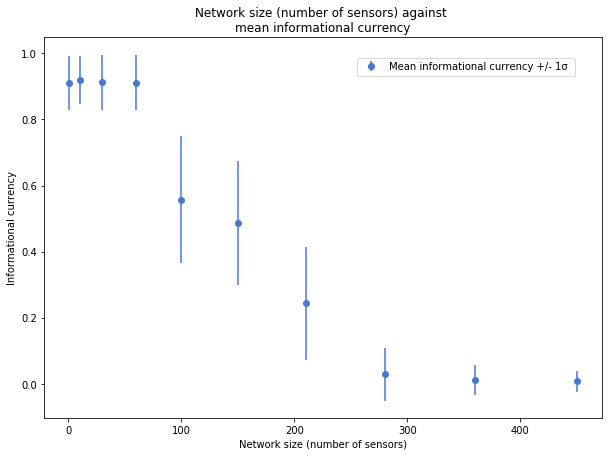

In [74]:
# Visualizing observations and OLS regression
plt.figure(figsize=(10,7))
plt.errorbar(num_sensors_model_df['num_sensors'], num_sensors_model_df['informational_currency_post_warmup_mean'], yerr=num_sensors_model_df['informational_currency_post_warmup_std'], fmt='o', label="Mean informational currency +/- 1σ ")
plt.legend(bbox_to_anchor=(0.96, 0.96))
# plt.text(20, 130, "y = " + str(round(gradient, 5)) + 'x + ' + str(round(intercept, 5)))
# plt.text(20,120,"p = " + str(round(pval, 5)))
# plt.text(20,110,r"$R^2$ = " + str(round(rsquared, 5)))

# add Rsquared, MSE, p-value
_ = plt.xlabel('Network size (number of sensors)')
_ = plt.ylabel('Informational currency')
_ = plt.title("Network size (number of sensors) against \nmean informational currency")

#### Interpretation

A convex negative nonlinear relationship appears to exist between network size and the measure of informational currency employed here. While a negative relationship was hypothesized, the nonlinear nature was unexpected. Further modeling and statistical analysis is warranted to better understand the dynamics of how network size affects how well the state of the cloud ledger reflects the state at the edge. 

Why?

### Assessing stationarity: informational currency over time

In order to analyze temporal autocorrelation and seasonality in measures of informational currency over time (after the warm-up period), 

ACF plot
PACF plots
Augmented Dickey-Fuller test

In [75]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

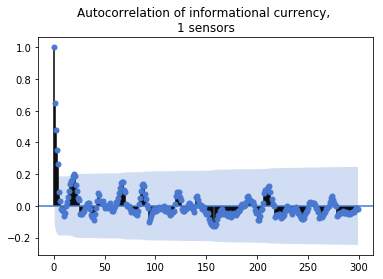

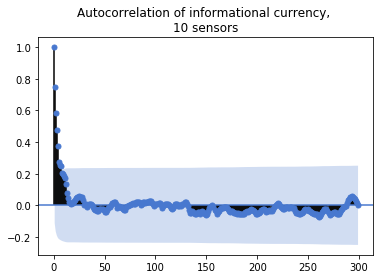

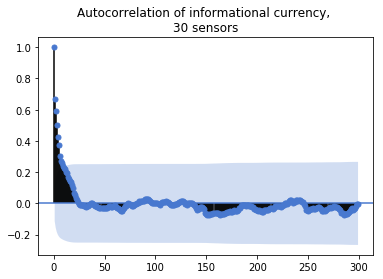

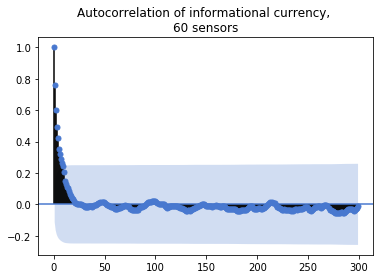

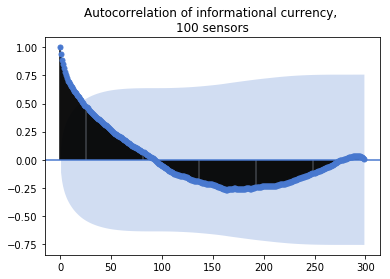

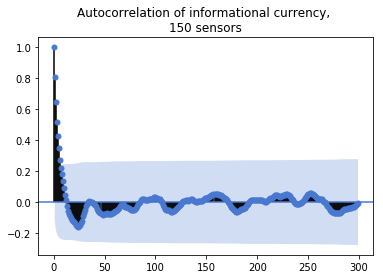

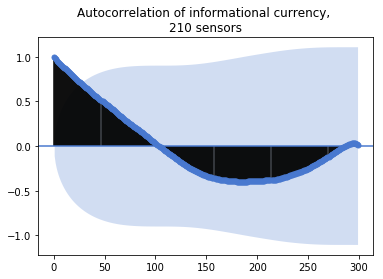

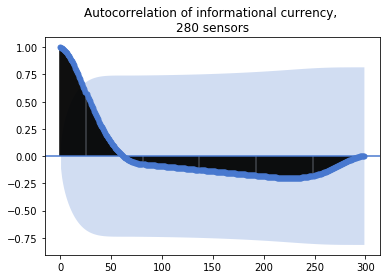

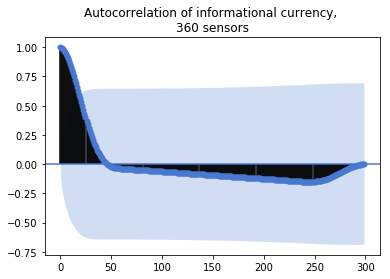

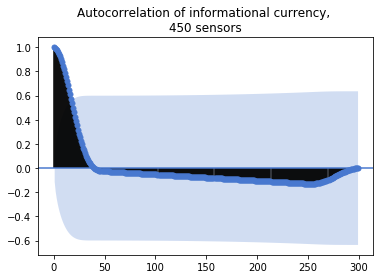

In [76]:
for i in range(len(num_sensors_model_df['agent_vars_by_tick'])):
    t = "Autocorrelation of informational currency, \n" + str(num_sensors_model_df.loc[i, 'num_sensors']) + " sensors"
    _ = plot_acf(num_sensors_model_df['agent_vars_by_tick'][i]['informational_currency'].unstack().mean(axis=1).values, title=t)

/Users/iv/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


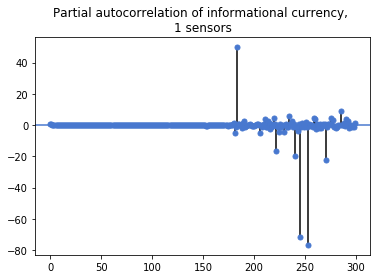

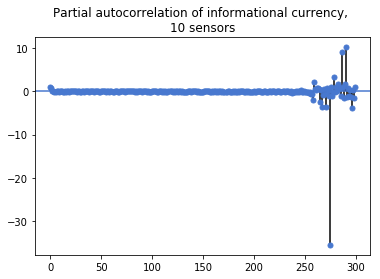

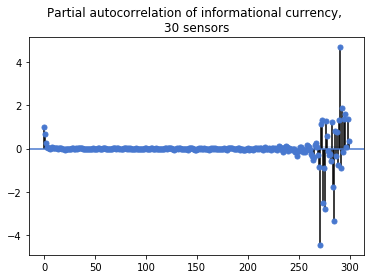

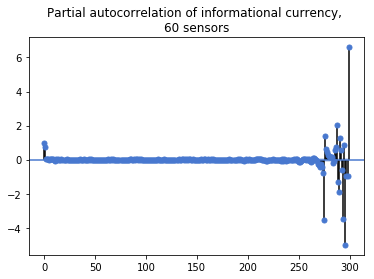

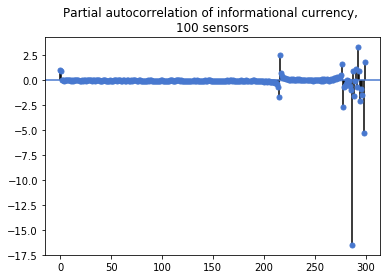

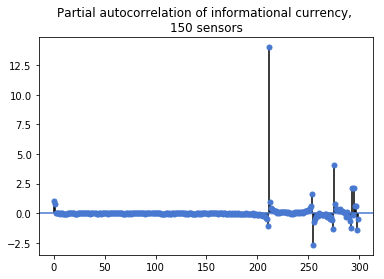

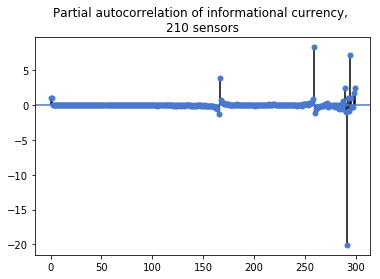

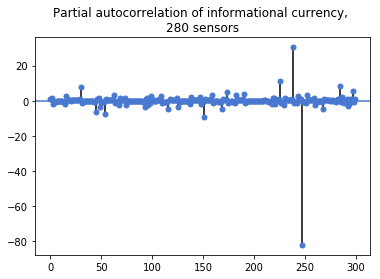

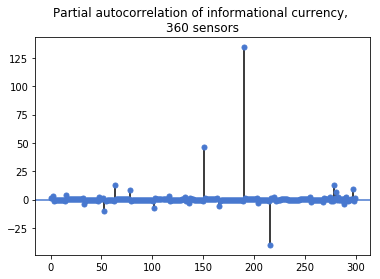

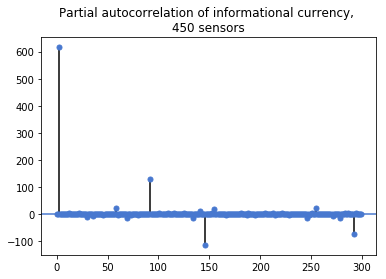

In [77]:
for i in range(len(num_sensors_model_df['agent_vars_by_tick'])):
    t = "Partial autocorrelation of informational currency, \n" + str(num_sensors_model_df.loc[i, 'num_sensors']) + " sensors"

    _ = plot_pacf(num_sensors_model_df['agent_vars_by_tick'][i]['informational_currency'].unstack().mean(axis=1).values, title=t)

In [78]:
# Adapted from CEGExxx: Spatial Temporal Data Analysis and Data Mining final project

from statsmodels.tsa.stattools import adfuller

for i in range(len(num_sensors_model_df['agent_vars_by_tick'])):

    adf_num_sensors = adfuller(num_sensors_model_df['agent_vars_by_tick'][i]['informational_currency'].unstack().mean(axis=1).values)
    print("Augmented Dickey-Fuller test, " + str(num_sensors_model_df.loc[i, 'num_sensors']) + " sensors")
    print('ADF Statistic: %f' % adf_num_sensors[0])
    print('p-value: %f' % adf_num_sensors[1])
    print('Critical Values:')
    for key, value in adf_num_sensors[4].items():
        print('\t%s: %.3f' % (key, value))
    print()

Augmented Dickey-Fuller test, 1 sensors
ADF Statistic: -6.469646
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572

Augmented Dickey-Fuller test, 10 sensors
ADF Statistic: -17.960211
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572

Augmented Dickey-Fuller test, 30 sensors
ADF Statistic: -22.443624
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572

Augmented Dickey-Fuller test, 60 sensors
ADF Statistic: -12.078556
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572

Augmented Dickey-Fuller test, 100 sensors
ADF Statistic: -1.453103
p-value: 0.556570
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572

Augmented Dickey-Fuller test, 150 sensors
ADF Statistic: -3.971254
p-value: 0.001569
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572

Augmented Dickey-Fuller test, 210 sensors
ADF Statistic: -0.170513
p-value: 0.941946
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572

Augmented Dickey-Fulle

### Interpretation

The p-value of <0.05 on each of the Augmented Dickey-Fuller tests performed on the time series data representing informational currency serves as statistically significant evidence of what was visually observed in both the series plot and the autocorrelation function plot: the series do not have unit roots, and are stationary processes. This is important because it suggests that, with all other factors remaining constant, for a given transaction volume per block informational currency establishes a stable level. The variation was observed around that mean was based on stochasticity of transaction transmission: if a sensor did not transmit for an unusually long period, its informational currency level likely increased as transactions already submitted to the chain were validated, increasing the proportion reflected on chain of data recorded at the edge. The important observation is the stationarity of the metric: if blockchain transaction volume processing capacity adapts in response to submitted volumes, or submitted volumes are adjusted through incentivization adjustments (i.e. gas costs), sustainable operation of the blockchain appears possible, in this regard.

## Effects on gwei spent

Perhaps the primary constraint unique to public blockchains is the requirement that users pay for compute and storage space used. This is a necessary attribute of the system, designed to prevent intentional abuse or unintentional misuse, which seems to be inevitable in permissionless, anonymous systems. 



In [99]:
pearson_gwei = num_sensors_model_df[['num_sensors', 'gwei_spent_mean']].corr()

X_values_gwei = sms.add_constant(num_sensors_model_df['num_sensors'])
regression_model_gwei_spent = sms.OLS(num_sensors_model_df['gwei_spent_mean'], X_values_gwei).fit()
print(regression_model_gwei_spent.summary())

                            OLS Regression Results                            
Dep. Variable:        gwei_spent_mean   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     55.43
Date:                Fri, 09 Aug 2019   Prob (F-statistic):           2.06e-06
Time:                        18:12:16   Log-Likelihood:                -189.98
No. Observations:                  17   AIC:                             384.0
Df Residuals:                      15   BIC:                             385.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.139e+05   7090.445     16.069      

/Users/iv/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


In [100]:
gradient_gwei = regression_model_gwei_spent.params[1]
intercept_gwei = regression_model_gwei_spent.params[0]
rsquared_gwei = regression_model_gwei_spent.rsquared
pval_gwei = regression_model_gwei_spent.f_pvalue

In [101]:
x_lobf_gwei = [num_sensors_model_df['num_sensors'].min(), num_sensors_model_df['num_sensors'].max()]
y_lobf_gwei = [x_lobf_gwei[0] * gradient_gwei + intercept_gwei, x_lobf_gwei[1] * gradient_gwei + intercept_gwei]

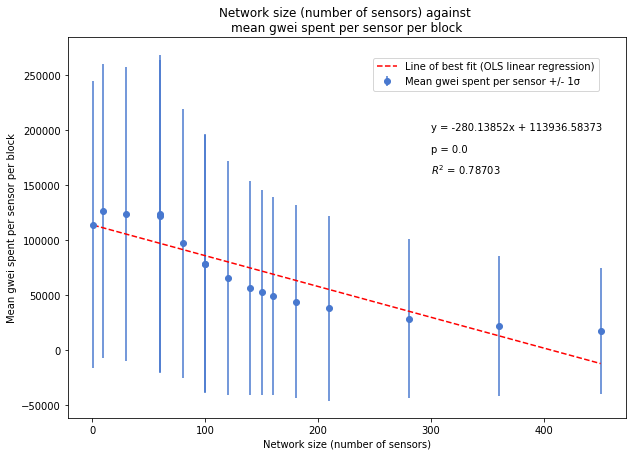

In [104]:

# Visualizing observations and OLS regression
plt.figure(figsize=(10,7))
plt.errorbar(num_sensors_model_df['num_sensors'], num_sensors_model_df['gwei_spent_mean'], yerr=num_sensors_model_df['gwei_spent_std'], fmt='o', label="Mean gwei spent per sensor +/- 1σ ")
plt.plot(x_lobf_gwei, y_lobf_gwei, 'r--', label="Line of best fit (OLS linear regression)" )
plt.legend(bbox_to_anchor=(0.96, 0.96))
plt.text(300, 200000, "y = " + str(round(gradient_gwei, 5)) + 'x + ' + str(round(intercept_gwei, 5)))
plt.text(300,180000,"p = " + str(round(pval_gwei, 5)))
plt.text(300,160000,r"$R^2$ = " + str(round(rsquared_gwei, 5)))

# add Rsquared, MSE, p-value
_ = plt.xlabel('Network size (number of sensors)')
_ = plt.ylabel('Mean gwei spent per sensor per block')
_ = plt.title("Network size (number of sensors) against \nmean gwei spent per sensor per block")

#### Interpretation 

An negative relationship is observed: as network size increases, average gwei spent per sensor per block decreases. This was expected given that each block has a fixed gas limit, here placing a limit on the amount of data that can be written to the blockchain each block validation - as the number of sensors attempting to submit data to be stored on chain increases, the likelihood of each sensor's transactions being validated, and contained data being written, decreases. Costs in gwei incurred are only deducted from the sensor's externally owned account upon transaction validation - the decrease in gwei spent relates closely to the decrease in informational currency observed.

While the p-value calculated for the line of best fit using OLS regression is below the 0.05 threshold set to accept significance, the non-normal distribution of residual errors suggests that a non-linear model may fit the data better. Further research into the nature of the relationship between network size (in effect, transaction volumes) and cost to each network participant is warranted. This is a point where deploying heterogeneous agents submitting transactions at differing frequencies and writing data of varying volumes could provide even further insight into network scalability. 

## The effects of record volumes on dependent variables

In [105]:
record_bytes_model_df = get_model_vars_df_from_pickle('./data/run-3/batch_run_1_record_bytes.pkl')

### Effects on mining dynamics

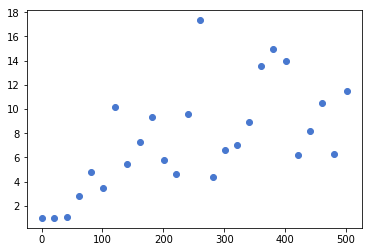

In [106]:
plt.scatter(record_bytes_model_df['record_bytes'], record_bytes_model_df['mining_mean'])

In [107]:
pearson_record_bytes = record_bytes_model_df[['record_bytes', 'mining_mean']].corr()

In [109]:
X_values_record_bytes = sms.add_constant(record_bytes_model_df['record_bytes'])
regression_model_record_bytes = sms.OLS(record_bytes_model_df['mining_mean'], X_values_record_bytes).fit()
print(regression_model_record_bytes.summary())

                            OLS Regression Results                            
Dep. Variable:            mining_mean   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     14.76
Date:                Fri, 09 Aug 2019   Prob (F-statistic):           0.000786
Time:                        18:14:59   Log-Likelihood:                -68.398
No. Observations:                  26   AIC:                             140.8
Df Residuals:                      24   BIC:                             143.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.1274      1.337      2.340   

In [110]:
gradient_record_bytes = regression_model_record_bytes.params[1]
intercept_record_bytes = regression_model_record_bytes.params[0]
rsquared_record_bytes = regression_model_record_bytes.rsquared
pval_record_bytes = regression_model_record_bytes.f_pvalue

In [111]:
x_lobf_record_bytes = [record_bytes_model_df['record_bytes'].min(), record_bytes_model_df['record_bytes'].max()]
y_lobf_record_bytes = [x_lobf_record_bytes[0]*gradient_record_bytes + intercept_record_bytes, x_lobf_record_bytes[1]*gradient_record_bytes + intercept_record_bytes]


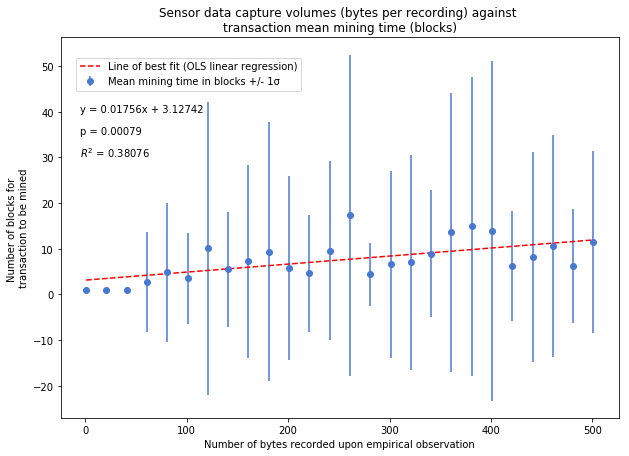

In [118]:
# Visualizing observations and OLS regression
plt.figure(figsize=(10,7))
plt.errorbar(record_bytes_model_df['record_bytes'], record_bytes_model_df['mining_mean'], yerr=record_bytes_model_df['mining_std'], fmt='o', label="Mean mining time in blocks +/- 1σ ")
plt.plot(x_lobf_record_bytes, y_lobf_record_bytes, 'r--', label="Line of best fit (OLS linear regression)" )
plt.legend(bbox_to_anchor=(0.44, 0.96))
plt.text(-5, 40, "y = " + str(round(gradient_record_bytes, 5)) + 'x + ' + str(round(intercept_record_bytes, 5)))
plt.text(-5,35,"p = " + str(round(pval_record_bytes, 5)))
plt.text(-5,30,r"$R^2$ = " + str(round(rsquared_record_bytes, 5)))

# add Rsquared, MSE, p-value
_ = plt.xlabel('Number of bytes recorded upon empirical observation')
_ = plt.ylabel('Number of blocks for \ntransaction to be mined')
_ = plt.title("Sensor data capture volumes (bytes per recording) against \ntransaction mean mining time (blocks)")

In [170]:
from pyd3 import interpolate, color

In [190]:
color_interpolator = interpolate.rgb('blue', 'red')

In [188]:
str(color_interpolator(0.5))

'#800080'

### Effects of data capture volumes on network informational currency

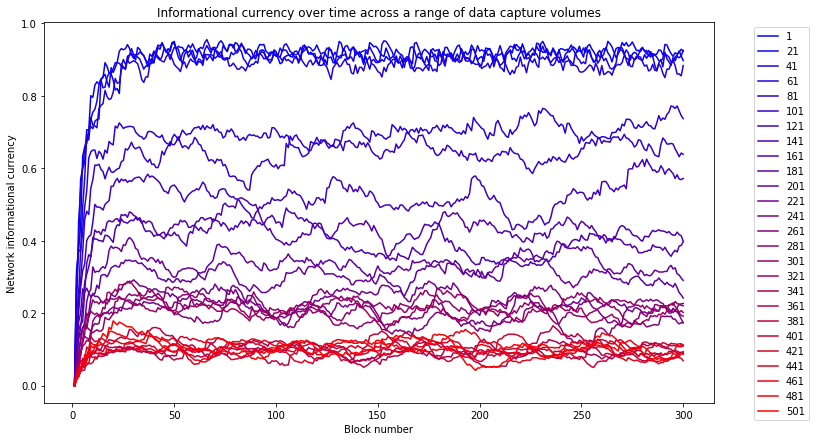

In [204]:
plt.figure(figsize=(12,7))
for i, run in record_bytes_model_df[['agent_vars_by_tick']].iterrows():
    plt.plot(run[0]['informational_currency'].unstack().mean(axis=1),\
             label=record_bytes_model_df.loc[i, 'record_bytes'], color=str(color_interpolator(record_bytes_model_df.loc[i, 'record_bytes'] / record_bytes_model_df['record_bytes'].max()))) #, cmap='gray', c=record_bytes_model_df['record_bytes'] )

plt.legend(bbox_to_anchor=(1.15, 1))
plt.title('Informational currency over time across a range of data capture volumes')
plt.xlabel('Block number')
_ = plt.ylabel("Network informational currency")
# num_sensors_model_df['agent_vars_by_tick']#[0].unstack()['informational_currency'].mean(axis=1).plot()

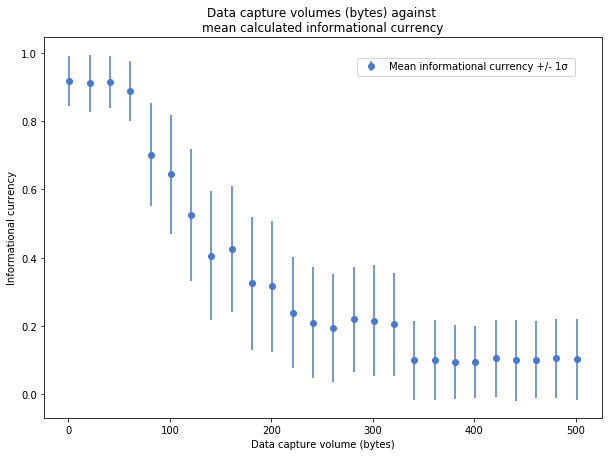

In [205]:
# Visualizing observations and OLS regression
plt.figure(figsize=(10,7))
plt.errorbar(record_bytes_model_df['record_bytes'], record_bytes_model_df['informational_currency_post_warmup_mean'], yerr=record_bytes_model_df['informational_currency_post_warmup_std'], fmt='o', label="Mean informational currency +/- 1σ ")
plt.legend(bbox_to_anchor=(0.96, 0.96))
# plt.text(20, 130, "y = " + str(round(gradient, 5)) + 'x + ' + str(round(intercept, 5)))
# plt.text(20,120,"p = " + str(round(pval, 5)))
# plt.text(20,110,r"$R^2$ = " + str(round(rsquared, 5)))

# add Rsquared, MSE, p-value
_ = plt.xlabel('Data capture volume (bytes)')
_ = plt.ylabel('Informational currency')
_ = plt.title("Data capture volumes (bytes) against \nmean calculated informational currency")

/Users/iv/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


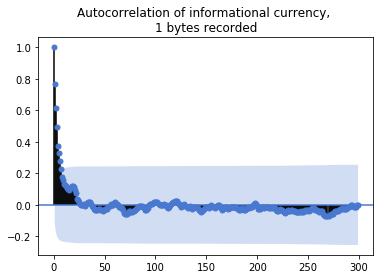

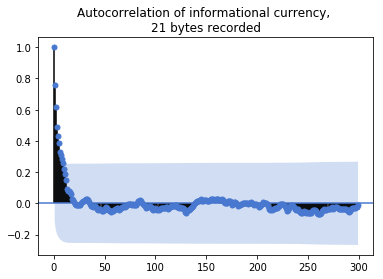

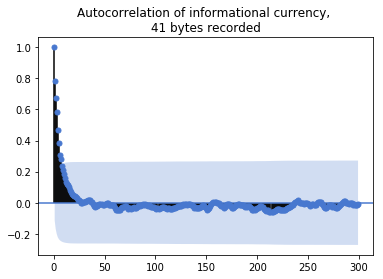

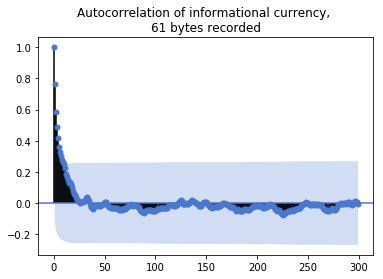

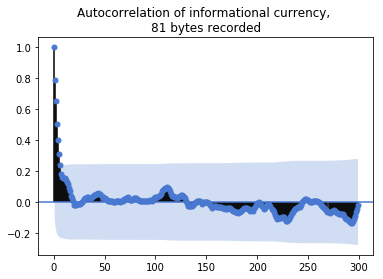

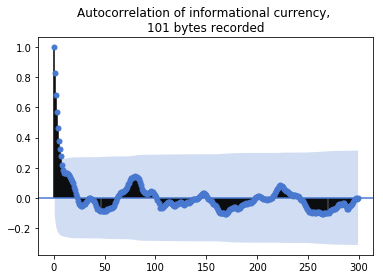

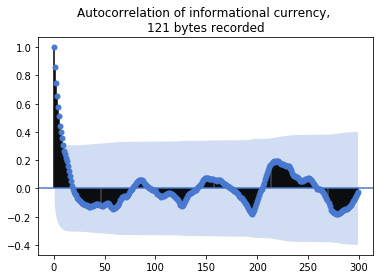

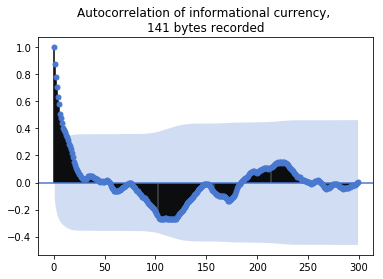

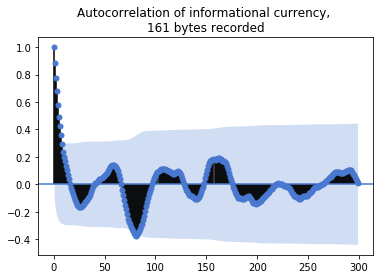

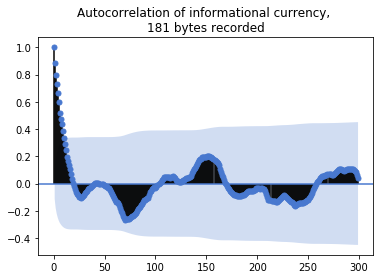

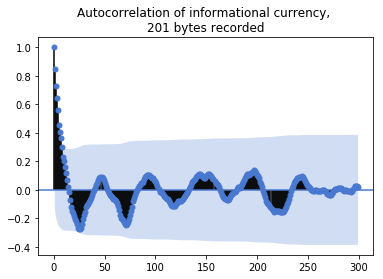

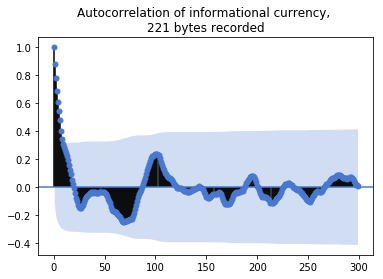

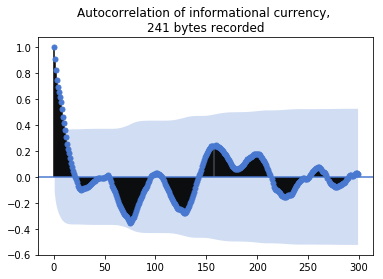

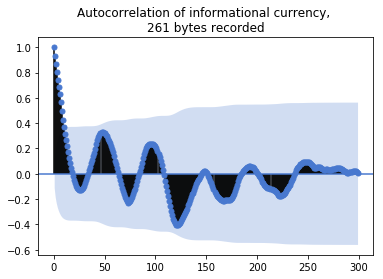

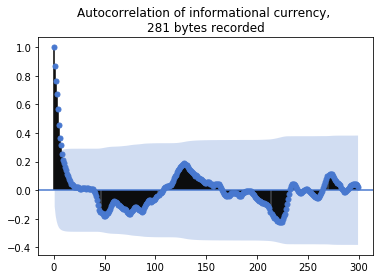

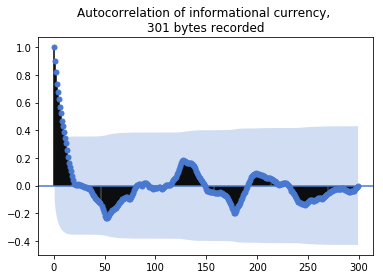

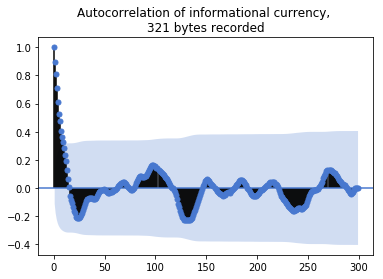

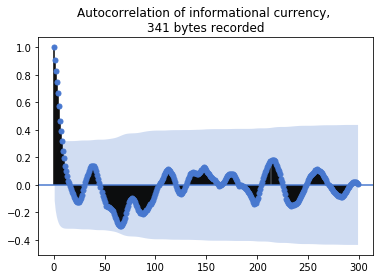

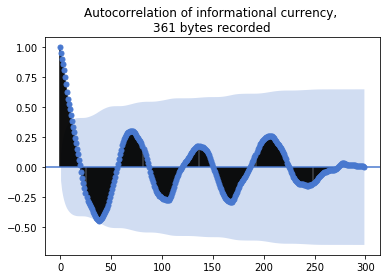

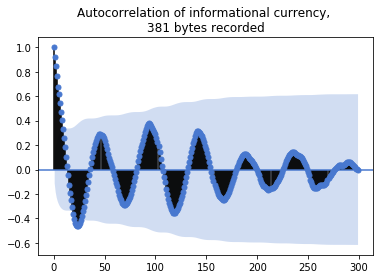

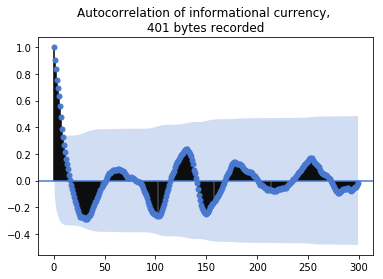

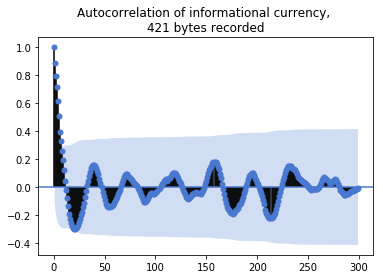

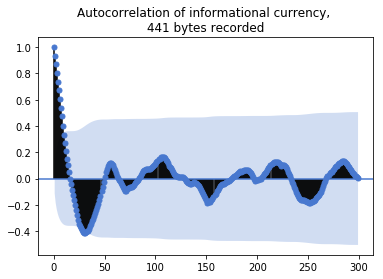

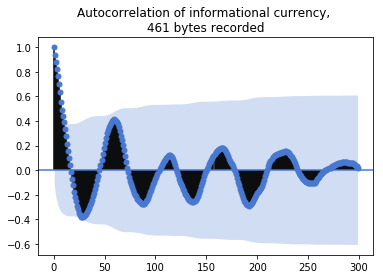

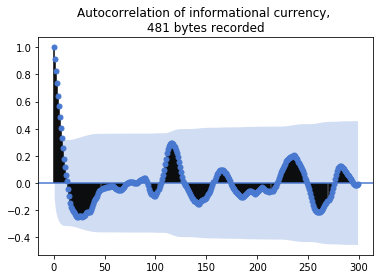

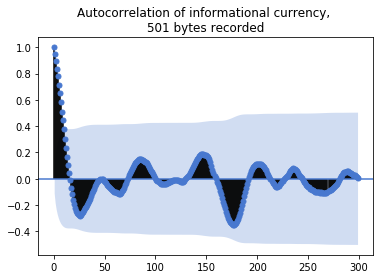

In [206]:
for i in range(len(record_bytes_model_df['agent_vars_by_tick'])):
    t = "Autocorrelation of informational currency, \n" + str(record_bytes_model_df.loc[i, 'record_bytes']) + " bytes recorded"
    _ = plot_acf(record_bytes_model_df['agent_vars_by_tick'][i]['informational_currency'].unstack().mean(axis=1).values, title=t)

Some cyclicity may appear in some of the higher recording volumes. 

This may be explained by the reduction in the number of transactions that can be validated per block. As transactions wait in the mempool, informational currency will decrease on each block - until it is validated, which would prompt a leap. However, informational currency is a measure of the state of the network, not an individual edge node (sensor) ...???

/Users/iv/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/Users/iv/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


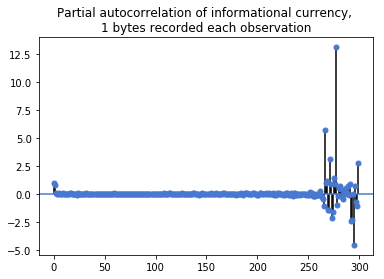

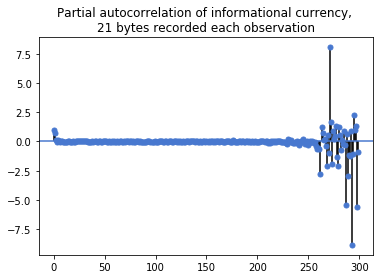

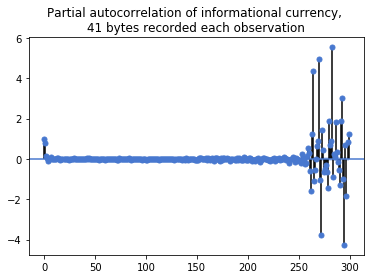

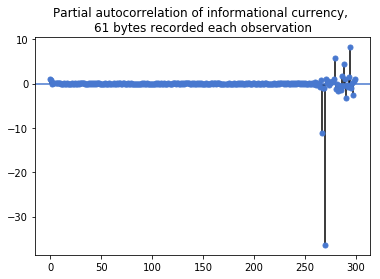

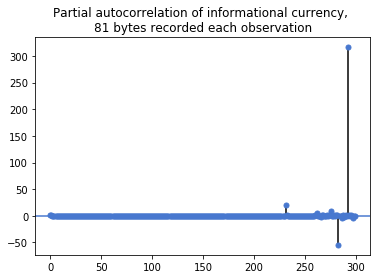

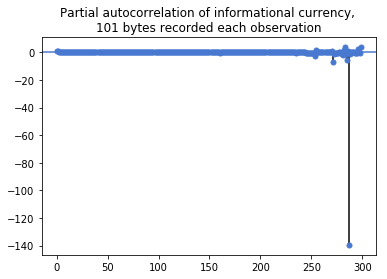

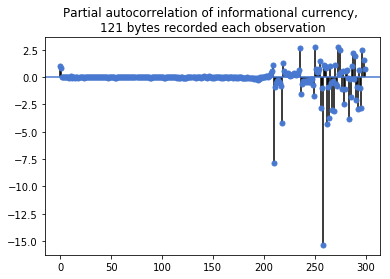

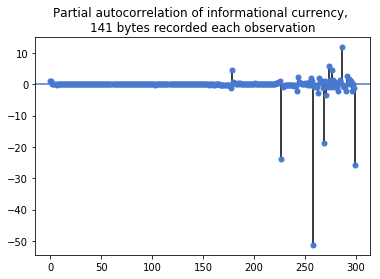

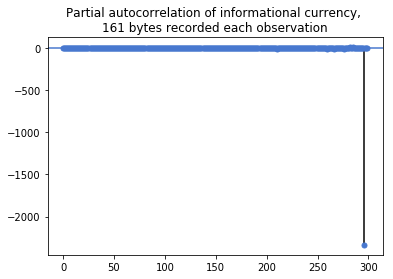

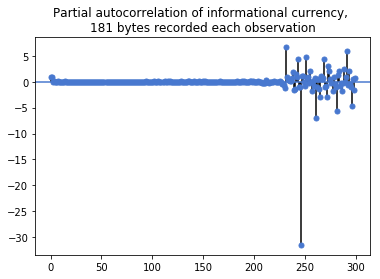

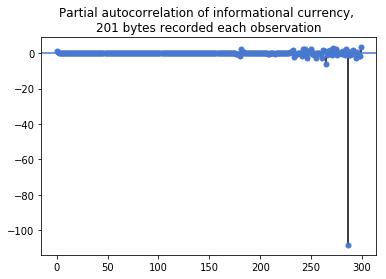

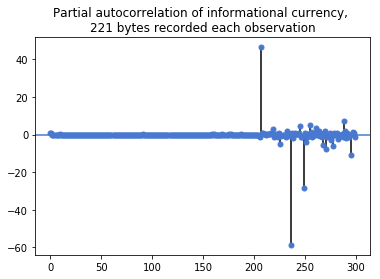

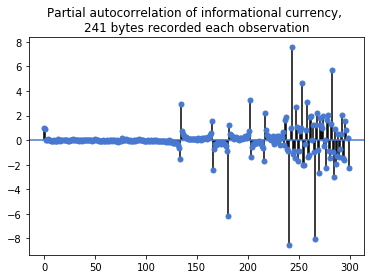

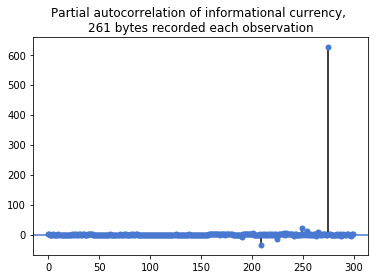

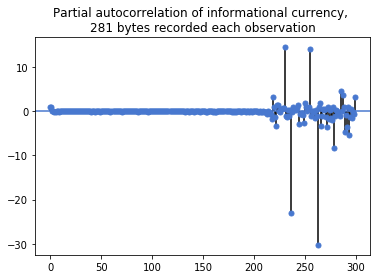

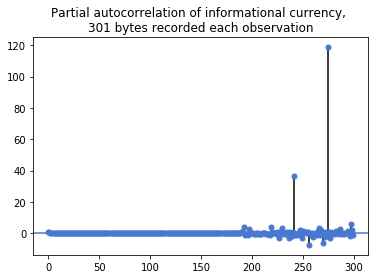

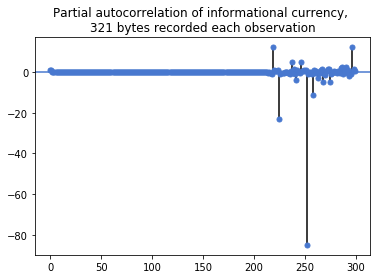

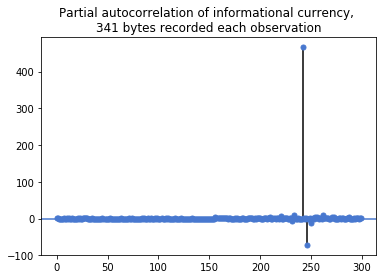

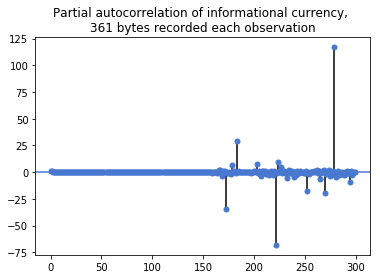

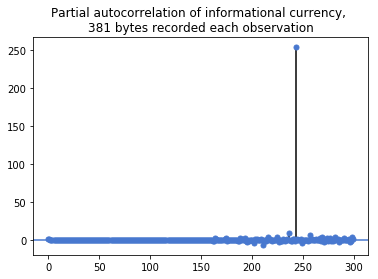

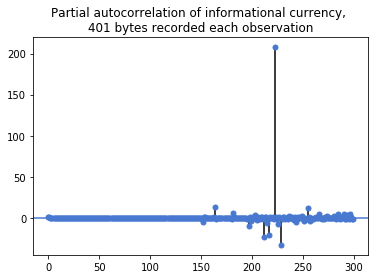

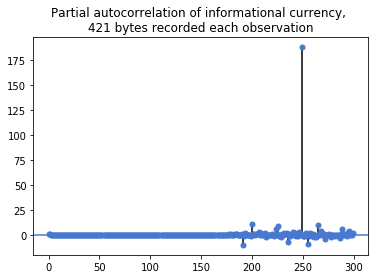

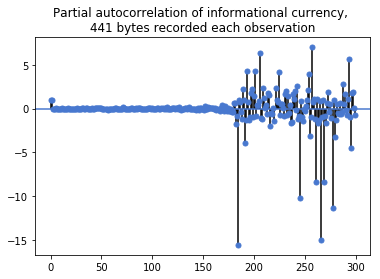

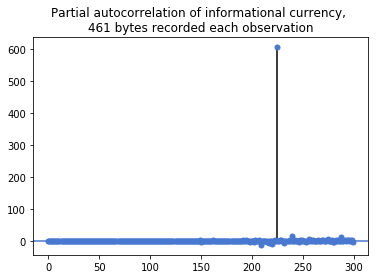

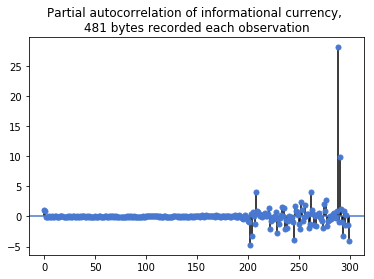

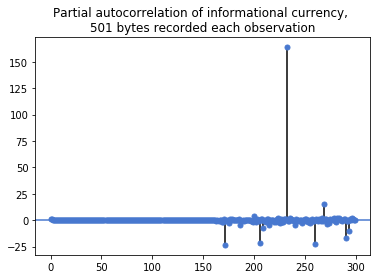

In [208]:
for i in range(len(record_bytes_model_df['agent_vars_by_tick'])):
    t = "Partial autocorrelation of informational currency, \n" + str(record_bytes_model_df.loc[i, 'record_bytes']) + " bytes recorded each observation"

    _ = plot_pacf(record_bytes_model_df['agent_vars_by_tick'][i]['informational_currency'].unstack().mean(axis=1).values, title=t)

In [209]:
# Adapted from CEGExxx: Spatial Temporal Data Analysis and Data Mining final project

for i in range(len(record_bytes_model_df['agent_vars_by_tick'])):

    adf_num_sensors = adfuller(record_bytes_model_df['agent_vars_by_tick'][i]['informational_currency'].unstack().mean(axis=1).values)
    print("Augmented Dickey-Fuller test, " + str(record_bytes_model_df.loc[i, 'record_bytes']) + " bytes recorded per observation")
    print('ADF Statistic: %f' % adf_num_sensors[0])
    print('p-value: %f' % adf_num_sensors[1])
    print('Critical Values:')
    for key, value in adf_num_sensors[4].items():
        print('\t%s: %.3f' % (key, value))
    print()

Augmented Dickey-Fuller test, 1 bytes recorded per observation
ADF Statistic: -5.385586
p-value: 0.000004
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572

Augmented Dickey-Fuller test, 21 bytes recorded per observation
ADF Statistic: -11.991287
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572

Augmented Dickey-Fuller test, 41 bytes recorded per observation
ADF Statistic: -19.230130
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572

Augmented Dickey-Fuller test, 61 bytes recorded per observation
ADF Statistic: -23.741228
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572

Augmented Dickey-Fuller test, 81 bytes recorded per observation
ADF Statistic: -5.500367
p-value: 0.000002
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572

Augmented Dickey-Fuller test, 101 bytes recorded per observation
ADF Statistic: -16.787178
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572

Augmented Dickey-Fuller 

Only a few p-values (241 bytes per obs, 181 bytes per obs) on the Augmented Dickey-Fuller tests indicated the rejection of the null hypothesis and the potential of the series having a unit root, indicating nonstationarity. 

In [214]:
pearson_gwei_record_bytes = record_bytes_model_df[['record_bytes', 'gwei_spent_mean']].corr()
pearson_gwei_record_bytes

,record_bytes,gwei_spent_mean
record_bytes,1.000000,-0.034889
gwei_spent_mean,-0.034889,1.000000


In [210]:
pearson_gwei_record_bytes = record_bytes_model_df[['record_bytes', 'gwei_spent_mean']].corr()

X_values_gwei_record_bytes = sms.add_constant(record_bytes_model_df['record_bytes'])
regression_model_gwei_spent_record_bytes = sms.OLS(record_bytes_model_df['gwei_spent_mean'], X_values_gwei_record_bytes).fit()
print(regression_model_gwei_spent_record_bytes.summary())

                            OLS Regression Results                            
Dep. Variable:        gwei_spent_mean   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.040
Method:                 Least Squares   F-statistic:                   0.02925
Date:                Fri, 09 Aug 2019   Prob (F-statistic):              0.866
Time:                        19:53:01   Log-Likelihood:                -331.37
No. Observations:                  26   AIC:                             666.7
Df Residuals:                      24   BIC:                             669.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2.989e+05    3.3e+04      9.056   

In [211]:
gradient_gwei_record_bytes = regression_model_gwei_spent_record_bytes.params[1]
intercept_gwei_record_bytes = regression_model_gwei_spent_record_bytes.params[0]
rsquared_gwei_record_bytes = regression_model_gwei_spent_record_bytes.rsquared
pval_gwei_record_bytes = regression_model_gwei_spent_record_bytes.f_pvalue

In [212]:
x_lobf_gwei_record_bytes = [record_bytes_model_df['record_bytes'].min(), record_bytes_model_df['record_bytes'].max()]
y_lobf_gwei_record_bytes = [x_lobf_gwei_record_bytes[0] * gradient_gwei_record_bytes + intercept_gwei_record_bytes, x_lobf_gwei_record_bytes[1] * gradient_gwei_record_bytes + intercept_gwei_record_bytes]

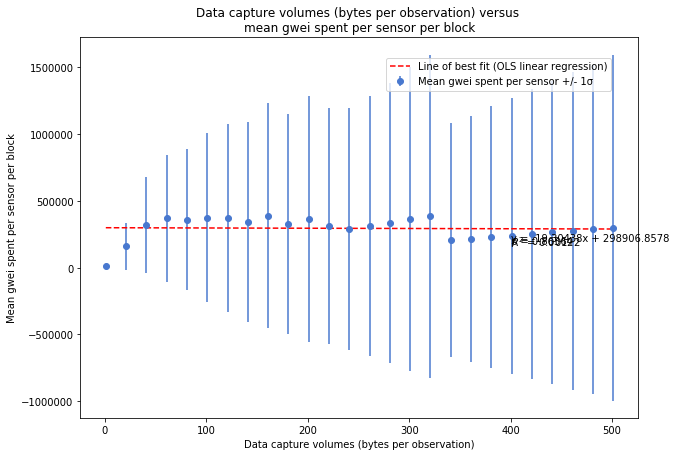

In [213]:

# Visualizing observations and OLS regression
plt.figure(figsize=(10,7))
plt.errorbar(record_bytes_model_df['record_bytes'], record_bytes_model_df['gwei_spent_mean'], yerr=record_bytes_model_df['gwei_spent_std'], fmt='o', label="Mean gwei spent per sensor +/- 1σ ")
plt.plot(x_lobf_gwei_record_bytes, y_lobf_gwei_record_bytes, 'r--', label="Line of best fit (OLS linear regression)" )
plt.legend(bbox_to_anchor=(0.96, 0.96))
plt.text(400, 200000, "y = " + str(round(gradient_gwei_record_bytes, 5)) + 'x + ' + str(round(intercept_gwei_record_bytes, 5)))
plt.text(400,180000,"p = " + str(round(pval_gwei_record_bytes, 5)))
plt.text(400,160000,r"$R^2$ = " + str(round(rsquared_gwei_record_bytes, 5)))

# add Rsquared, MSE, p-value
_ = plt.xlabel('Data capture volumes (bytes per observation)')
_ = plt.ylabel('Mean gwei spent per sensor per block')
_ = plt.title("Data capture volumes (bytes per observation) versus \nmean gwei spent per sensor per block")

Extremely low Pearson correlation coefficient suggests that no relationship exists between the mean gwei spent per sensor per block ...

This seems weird?

In [ ]:
plt.figure(figsize=(12,7))
for i, run in num_sensors_model_df[['agent_vars_by_tick']].iterrows():
    plt.plot(run[0]['informational_currency'].unstack().mean(axis=1),label=num_sensors_model_df.loc[i, 'num_sensors'] )
    
plt.legend()
# num_sensors_model_df['agent_vars_by_tick']#[0].unstack()['informational_currency'].mean(axis=1).plot()

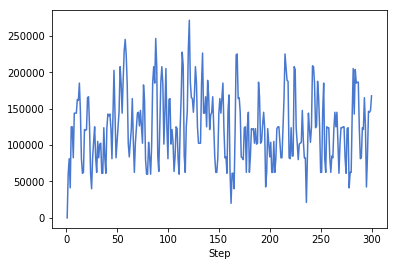

In [8]:
model_dfs['agent_vars_by_tick'][0].unstack()['gwei_spent'].mean(axis=1).plot()

In [9]:
dvs = ['gwei_spent', 'battery_life', 'data_collected', 'informational_currency']

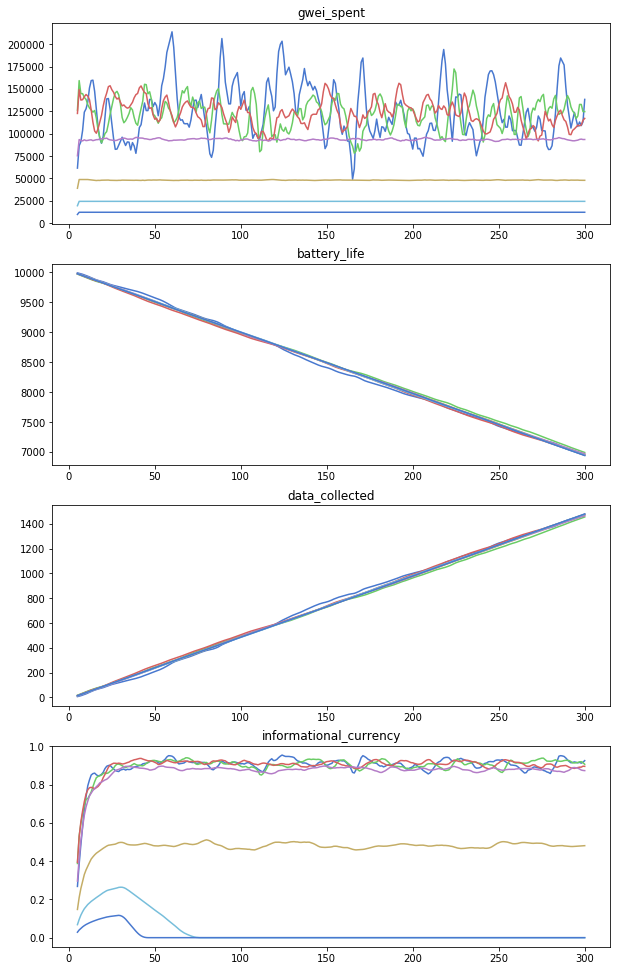

In [10]:
plt.figure(figsize=(10,17))
for i, dv in enumerate(dvs):
    plt.subplot(411 + i)
    plt.title(dv)
    for j, row in model_dfs.iterrows():
        plt.plot(row['agent_vars_by_tick'].unstack()[dv].mean(axis=1).rolling(5).mean(), label= str(row['record_freq']))


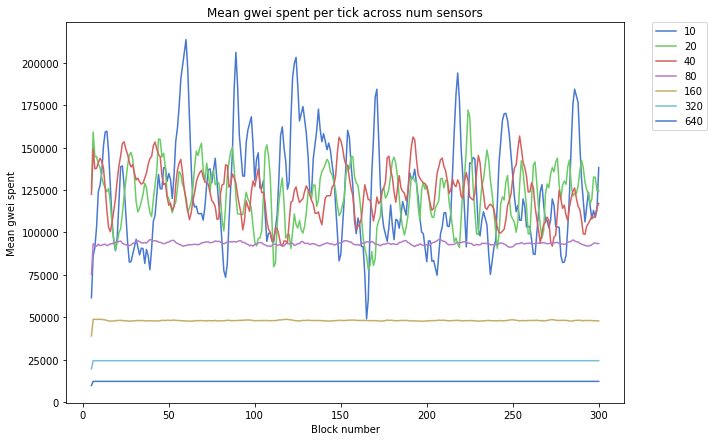

In [12]:
plt.figure(figsize=(10,7))
plt.title('Mean gwei spent per tick across num sensors')
for i, row in model_dfs.iterrows():
    plt.plot(row['agent_vars_by_tick'].unstack()['gwei_spent'].mean(axis=1).rolling(5).mean(), label= str(row['num_sensors']))

plt.ylabel('Mean gwei spent')
plt.xlabel('Block number')
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
# Examine descriptive statistics for each record frequency in a table

In [ ]:
# Examine correlation coefficients and say whether there is a trend

In [ ]:
# Calculate Z statistics to see if differences in distributions are statistically significant (they should be)

In [16]:
model_dfs

,num_sensors,Run,agent_vars_by_tick,mining_summary,model_vars_by_tick,blockchain_gas_price,block_gas_limit,gas_per_byte,gas_per_second,avg_block_time,...,record_freq,mining_count,mining_mean,mining_std,mining_min,mining_25%,mining_50%,mining_75%,mining_max,mining_frac_unmined
0,10,0,gwei_spent battery_life data_c...,count 1505.0 mean 1.0 ...,active_sensors 0 10 1 ...,20,8000000,625,75000000,13,...,0.3,1505.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0,0.000000
1,20,1,gwei_spent battery_life data_c...,count 2999.000000 mean ...,active_sensors 0 20 1 ...,20,8000000,625,75000000,13,...,0.3,2999.0,1.003334,0.057658,1.0,1.0,1.0,1.0,2.0,0.000000
2,40,2,gwei_spent battery_life data_c...,count 6089.000000 mean ...,active_sensors 0 40 1 ...,20,8000000,625,75000000,13,...,0.3,6089.0,1.001807,0.042468,1.0,1.0,1.0,1.0,2.0,0.000000
3,80,3,gwei_spent battery_life data_c...,count 10397.000000 mean ...,active_sensors 0 80 1 ...,20,8000000,625,75000000,13,...,0.3,10397.0,2.318073,6.424294,1.0,1.0,1.0,1.0,45.0,0.140246
4,160,4,gwei_spent battery_life data_c...,count 11413.000000 mean ...,active_sensors 0 160 1 ...,20,8000000,625,75000000,13,...,0.3,11413.0,16.656182,49.331449,1.0,1.0,1.0,1.0,261.0,0.533115
5,320,5,gwei_spent battery_life data_c...,count 11661.000000 mean ...,active_sensors 0 320 1 ...,20,8000000,625,75000000,13,...,0.3,11661.0,63.296544,36.177128,2.0,31.0,63.0,94.0,125.0,0.761641
6,640,6,gwei_spent battery_life data_c...,count 11661.000000 mean ...,active_sensors 0 640 1 ...,20,8000000,625,75000000,13,...,0.3,11661.0,107.120573,61.072187,2.0,54.0,107.0,160.0,213.0,0.881090


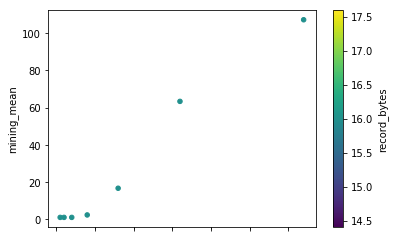

In [15]:
model_dfs.plot.scatter(x='num_sensors', y='mining_mean', c='info', cmap='viridis')

In [ ]:
plt.plot(model_dfs[''])

In [54]:
for rbytes in model_dfs['record_bytes'].unique():
    print(rbytes)

1
10
100


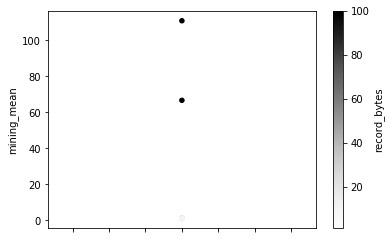

In [51]:
model_dfs[model_dfs['record_freq'] == 0.1].plot.scatter(x='record_freq', y='mining_mean', c='record_bytes')